# Problem Session 8
## Classifying Cancer II

In this notebook you continue to work with the cancer data set that can be found here, <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29">https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29</a>. 

The problems in this notebook will cover the content covered in some of our `Classification` notebooks as well as some of our `Dimension Reduction` notebooks. In particular we will cover content touched on in:
- `Classification/Adjustments for Classification`,
- `Classification/k Nearest Neighbors`,
- `Classification/The Confusion Matrix`,
- `Classification/Logistic Regression`,
- `Classification/Diagnostic Curves`,
- `Classification/Bayes Based Classifiers` and
- `Dimension Reduction/Principal Components Analysis`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

##### 1. Load the data.

The data for this problem is stored in `sklearn`, here is the documentation page for that, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html">https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html</a>.

Run this code chunk to load in the data.

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [3]:
## Loads the data from sklearn 
cancer = load_breast_cancer(as_frame=True)

## the 'data' entry contains the features
X = cancer['data']

## the 'target' entry contains what we would like to predict
y = cancer['target']

## Chaning the labels around
y = -y + 1

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(),
                                                       shuffle=True,
                                                       random_state=214,
                                                       stratify=y,
                                                       test_size=.2)

##### 2. Remind yourselves

Take a few minutes to review `Problem Session 7` if you need to to remind yourselves about this data set and the overall goal of the problem.

##### 3. Dimension reduction

The cancer data set has $30$ features. While this does not seem like a large number of features, there may be a number of features that add <i>noise</i> to the data set with respect to separating our variable of interest, $y$.

One way to denoise the data is to run it through a dimension reduction technique. 

Run the features of the training set through principal components analysis (PCA) and reduce $30$ features down to $2$. Make a scatter plot with the first PCA values plotted on the horizontal axis and the second PCA values plotted on the vertical, color the points by their $y$ values. Comment on what you see.

<i>Hint: Remember that you have to scale the data prior to fitting the PCA.</i>

##### Sample Solution

In [5]:
## Import what you'll need
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [6]:
## Make a pipeline for your PCA
pipe = Pipeline([('scale', StandardScaler()),
                    ('pca', PCA(2))])


pipe.fit(X_train.values)

fit = pipe.transform(X_train.values)

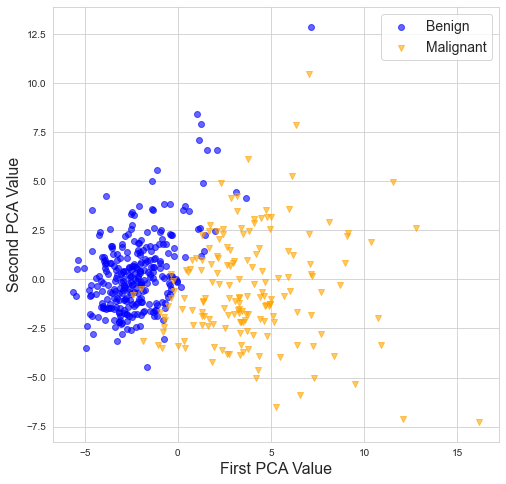

In [7]:
plt.figure(figsize=(8,8))

plt.scatter(fit[y_train==0, 0],
               fit[y_train==0, 1],
               c = 'b',
               alpha = .6,
               label='Benign')

plt.scatter(fit[y_train==1, 0],
               fit[y_train==1, 1],
               c = 'orange',
               marker = 'v',
               alpha = .6,
               label='Malignant')

plt.legend(fontsize=14)

plt.xlabel("First PCA Value", fontsize=16)
plt.ylabel("Second PCA Value", fontsize=16)

plt.show()

##### 4. Build a Model 

Fill in the cross-validation code provided below to build a $k$-nearest neighbors model using the PCA processed data you generated above. What was the average TPR, FPR and precision for such a model?

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.neighbors import KNeighborsClassifier

In [9]:
kfold = StratifiedKFold(5, shuffle=True, random_state=14235)


knn_tprs = np.zeros(5)
knn_fprs = np.zeros(5)
knn_precs = np.zeros(5)



i = 0
for train_index, test_index in kfold.split(X_train, y_train.values):
    X_tt = X_train.iloc[train_index]
    X_ho = X_train.iloc[test_index]
    y_tt = y_train.iloc[train_index]
    y_ho = y_train.iloc[test_index]
    
    knn_pipe = Pipeline([('scale', StandardScaler()),
                    ('pca', PCA(2)),
                    ('knn', KNeighborsClassifier(10))])
    
    knn_pipe.fit(X_tt.values, y_tt.values)

    pred = knn_pipe.predict(X_ho.values)

    knn_precs[i] = precision_score(y_ho.values, pred)
    conf_mat = confusion_matrix(y_ho.values, pred)

    knn_tprs[i] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
    knn_fprs[i] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])

    i = i + 1

In [10]:
print("Mean CV TPR =", np.round(np.mean(knn_tprs),3))
print()
print("Mean CV FPR =", np.round(np.mean(knn_fprs),3))
print()
print("Mean CV Prec =", np.round(np.mean(knn_precs),3))

Mean CV TPR = 0.9

Mean CV FPR = 0.035

Mean CV Prec = 0.942


##### 5. Optimizing explained variance

In our PCA lecture notebooks we discussed how you could choose a number of PCA components using the explained variance ratio. However, when you use PCA as a preprocessing step for a supervised learning algorithm you can perform a cross-validation optimization instead.

Fill in the missing code in the chunks below to tune the fraction of total explained variance used in the PCA step.

What are the explained variance ratios with the best average CV TPR, FPR and precision?

In [11]:
fracs = np.arange(.01, 1, .01)

pca_tprs = np.zeros((5, len(fracs)))
pca_fprs = np.zeros((5, len(fracs)))
pca_precs = np.zeros((5, len(fracs)))

i = 0
for train_index, test_index in kfold.split(X_train, y_train.values):
    X_tt = X_train.iloc[train_index]
    X_ho = X_train.iloc[test_index]
    y_tt = y_train.iloc[train_index]
    y_ho = y_train.iloc[test_index]
    
    j = 0
    for frac in fracs:
        knn_pipe = Pipeline([('scale', StandardScaler()),
                        ('pca', PCA(n_components=frac)),
                        ('knn', KNeighborsClassifier(10))])
        
        knn_pipe.fit(X_tt.values, y_tt.values)
        
        pred = knn_pipe.predict(X_ho.values)

        pca_precs[i,j] = precision_score(y_ho.values, pred)
        
        
        conf_mat = confusion_matrix(y_ho.values, pred)
        
        pca_tprs[i,j] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
        pca_fprs[i,j] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
        j = j + 1

    i = i + 1

In [12]:
print("TPR")
print("==============================")
print("The explained variance ration with the highest avg. cv TPR was",
          fracs[np.argmax(np.mean(pca_tprs, axis=0))])
print("This feature produced a model with avg. cv. TPR of",np.round(np.max(np.mean(pca_tprs, axis=0)),4))
print()

print("FPR")
print("==============================")
print("The explained variance ration with the lowest avg. cv FPR was",
          fracs[np.argmin(np.mean(pca_fprs, axis=0))])
print("This feature produced a model with avg. cv. FPR of",np.round(np.min(np.mean(pca_fprs, axis=0)),4))
print()

print("Precision")
print("==============================")
print("The explained variance ration with the highest avg. cv Precision was",
          fracs[np.argmax(np.mean(pca_precs, axis=0))])
print("This feature produced a model with avg. cv. Precision of",np.round(np.max(np.mean(pca_precs, axis=0)),4))

TPR
The explained variance ration with the highest avg. cv TPR was 0.44
This feature produced a model with avg. cv. TPR of 0.9118

FPR
The explained variance ration with the lowest avg. cv FPR was 0.79
This feature produced a model with avg. cv. FPR of 0.0035

Precision
The explained variance ration with the highest avg. cv Precision was 0.9600000000000001
This feature produced a model with avg. cv. Precision of 0.9938


##### 6. Make some diagnostic curves

While you found the explained variance ratio with the best TPR, FPR and precision, we are often interested in the tradeoffs between such metrics. For example, a true postive rate of $1$ could be useless if that comes with a very high false positive rate.

Plot the the average CV performance for all three of these metrics against the explained variance ratio in the same figure.

Then thinking in terms of what it translates to for our problem of classifying cancer, select a value for the explained variance ratio to form a final PCA $k$NN model.

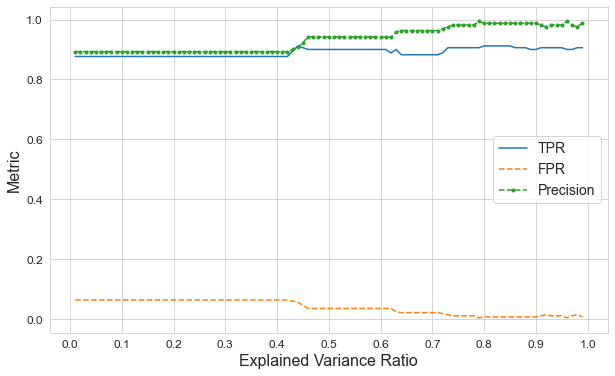

In [16]:
plt.figure(figsize=(10,6))

plt.plot(fracs, np.mean(pca_tprs, axis=0), '-', label="TPR")
plt.plot(fracs, np.mean(pca_fprs, axis=0), '--', label="FPR")
plt.plot(fracs, np.mean(pca_precs, axis=0), '--.', label="Precision")

plt.xlabel("Explained Variance Ratio", fontsize=16)
plt.ylabel("Metric", fontsize=16)

plt.yticks(fontsize=12)
plt.xticks(np.arange(0,1.1,.1), fontsize=12)


plt.legend(fontsize=14)

plt.show()

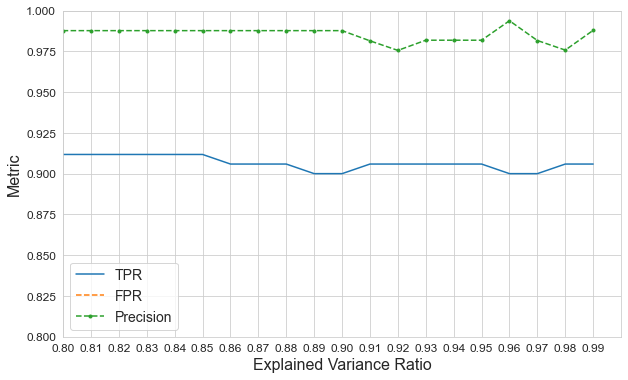

In [14]:
plt.figure(figsize=(10,6))

plt.plot(fracs, np.mean(pca_tprs, axis=0), '-', label="TPR")
plt.plot(fracs, np.mean(pca_fprs, axis=0), '--', label="FPR")
plt.plot(fracs, np.mean(pca_precs, axis=0), '--.', label="Precision")

plt.xlabel("Explained Variance Ratio", fontsize=16)
plt.ylabel("Metric", fontsize=16)

plt.yticks(fontsize=12)

plt.ylim([.8,1])
plt.xlim([.8,1])
plt.xticks(np.arange(.8,1,.01), fontsize=12)


plt.legend(fontsize=14)

plt.show()

I would go with $0.85$.

##### 7. Trying Bayes based classifiers

Build LDA, QDA and naive Bayes' models on these data by filling in the missing code for the cross-validation below. 

Do these outperform your PCA-$k$NN models from above?

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [18]:
kfold = StratifiedKFold(5, shuffle=True, random_state=14235)


da_tprs = np.zeros((5,3))
da_fprs = np.zeros((5,3))
da_precs = np.zeros((5,3))



i = 0
for train_index, test_index in kfold.split(X_train, y_train.values):
    X_tt = X_train.iloc[train_index]
    X_ho = X_train.iloc[test_index]
    y_tt = y_train.iloc[train_index]
    y_ho = y_train.iloc[test_index]
    
    lda_pipe = Pipeline([('scale', StandardScaler()),
                    ('lda', LinearDiscriminantAnalysis())])
    
    qda_pipe = Pipeline([('scale', StandardScaler()),
                    ('qda', QuadraticDiscriminantAnalysis())])
    
    nb_pipe = Pipeline([('scale', StandardScaler()),
                    ('qda', GaussianNB())])
    
    lda_pipe.fit(X_tt.values, y_tt.values)
    qda_pipe.fit(X_tt.values, y_tt.values)
    nb_pipe.fit(X_tt.values, y_tt.values)



    lda_pred = lda_pipe.predict(X_ho.values)
    qda_pred = qda_pipe.predict(X_ho.values)
    nb_pred = nb_pipe.predict(X_ho.values)



    da_precs[i,0] = precision_score(y_ho.values, lda_pred)
    da_precs[i,1] = precision_score(y_ho.values, qda_pred)
    da_precs[i,2] = precision_score(y_ho.values, nb_pred)

    

    lda_conf_mat = confusion_matrix(y_ho.values, lda_pred)
    qda_conf_mat = confusion_matrix(y_ho.values, qda_pred)
    nb_conf_mat = confusion_matrix(y_ho.values, nb_pred)



    da_tprs[i,0] = lda_conf_mat[1,1]/(lda_conf_mat[1,0] + lda_conf_mat[1,1])
    da_fprs[i,0] = lda_conf_mat[0,1]/(lda_conf_mat[0,0] + lda_conf_mat[0,1])

    da_tprs[i,1] = qda_conf_mat[1,1]/(qda_conf_mat[1,0] + qda_conf_mat[1,1])
    da_fprs[i,1] = qda_conf_mat[0,1]/(qda_conf_mat[0,0] + qda_conf_mat[0,1])
    
    da_tprs[i,2] = nb_conf_mat[1,1]/(nb_conf_mat[1,0] + nb_conf_mat[1,1])
    da_fprs[i,2] = nb_conf_mat[0,1]/(nb_conf_mat[0,0] + nb_conf_mat[0,1])



    i = i + 1

In [19]:
print("TPR")
print("==============================")
print("LDA:", np.mean(da_tprs[:,0]))
print("QDA:", np.mean(da_tprs[:,1]))
print("NB:", np.mean(da_tprs[:,2]))
print()

print("FPR")
print("==============================")
print("LDA:", np.mean(da_fprs[:,0]))
print("QDA:", np.mean(da_fprs[:,1]))
print("NB:", np.mean(da_fprs[:,2]))
print()

print("Precision")
print("==============================")
print("LDA:", np.mean(da_precs[:,0]))
print("QDA:", np.mean(da_precs[:,1]))
print("NB:", np.mean(da_precs[:,2]))
print()

TPR
LDA: 0.8882352941176469
QDA: 0.9647058823529413
NB: 0.9117647058823529

FPR
LDA: 0.003508771929824561
QDA: 0.045614035087719294
NB: 0.04912280701754386

Precision
LDA: 0.9935483870967742
QDA: 0.9285664906988436
NB: 0.9189655958077012



##### 8. LDA for supervised dimensionality reduction

While we introduced linear discriminant analysis (LDA) as a classification algorithm, it was originally proposed by Fisher as a supervised dimension reduction technique, <a href="https://digital.library.adelaide.edu.au/dspace/bitstream/2440/15227/1/138.pdf">https://digital.library.adelaide.edu.au/dspace/bitstream/2440/15227/1/138.pdf</a>. In particular, the initial goal was to project the features, $X$, corresponding to a binary output, $y$, onto a single dimension which best separates the possible classes. This single dimension has come to been known as <i>Fisher's discriminant</i>.

Walk through the code below to perform this supervised dimension reduction technique on these Cancer data.

In [20]:
## First we make a validation set for demonstration purposes
X_tt, X_val, y_tt, y_val = train_test_split(X_train.copy(), y_train,
                                               shuffle=True,
                                               random_state=302,
                                               test_size = .2,
                                               stratify = y_train)

In [21]:
## Make a pipeline that scales the data
## and ends with LDA
pipe = Pipeline([('scale', StandardScaler()),
                    ('lda', LinearDiscriminantAnalysis())])

In [22]:
## Fit the pipeline like you would
## for a classifier
pipe.fit(X_tt, y_tt)

Pipeline(steps=[('scale', StandardScaler()),
                ('lda', LinearDiscriminantAnalysis())])

In [23]:
## Now instead of pipe.predict
## call pipe.transform, like a PCA object
## use the training features as input
pipe.transform(X_tt)

array([[ 2.18498431e-01],
       [ 3.75573799e+00],
       [ 3.30687394e+00],
       [ 1.06939772e+00],
       [-1.85505196e+00],
       [-1.31277268e+00],
       [-1.33302195e+00],
       [ 4.53831825e+00],
       [-1.09204759e+00],
       [-1.97683680e+00],
       [-1.88418193e+00],
       [-8.38083355e-01],
       [-1.28030401e+00],
       [-2.06942820e+00],
       [-2.03652071e+00],
       [ 3.71885464e+00],
       [-3.24435061e+00],
       [-1.30639047e+00],
       [-2.53553505e+00],
       [ 3.74173514e+00],
       [-1.02086101e+00],
       [-2.05759635e+00],
       [-2.84824678e+00],
       [-1.53937184e+00],
       [-2.04702779e+00],
       [ 2.52869628e+00],
       [-2.42728815e+00],
       [-2.37553598e+00],
       [-2.69448103e+00],
       [-2.79957741e+00],
       [-1.57378989e+00],
       [-1.98487292e+00],
       [-4.16498889e-01],
       [-1.16051488e+00],
       [ 2.87414527e+00],
       [ 3.02585607e+00],
       [ 2.09836822e+00],
       [-1.62716186e+00],
       [ 3.5

Here we have projected this $30$-dimensional data onto a $1$-dimensional space that maximizes the separation between classes $0$ and $1$. We can visualize this by plotting a histogram split by class.

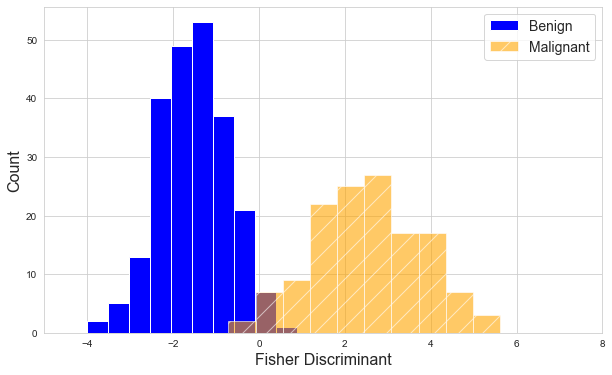

In [24]:
plt.figure(figsize=(10,6))

plt.hist(pipe.transform(X_tt)[y_tt==0], color='blue', label="Benign")
plt.hist(pipe.transform(X_tt)[y_tt==1], color='orange', hatch='/', alpha=.6, label="Malignant")

plt.xlabel("Fisher Discriminant", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.legend(fontsize=14)

plt.xlim([-5,8])

plt.show()

From this we can see there is very little overlap in the values of the Fisher discriminant for the two types of tumor.

We could use the discriminant in order to make classifications, for example by setting a simple cutoff value or as input into a different classification algorithm.

However, it is important to note that the LDA algorithm maximizes the separation of the two classes among observations of the training set. It is possible that such good separation would not occur using data the algorithm was not trained on.

In this example we can visually inspect by plotting a histogram of the Fisher discriminant values for the validation set we created. Does the separation seem as pronounced on the validation data?

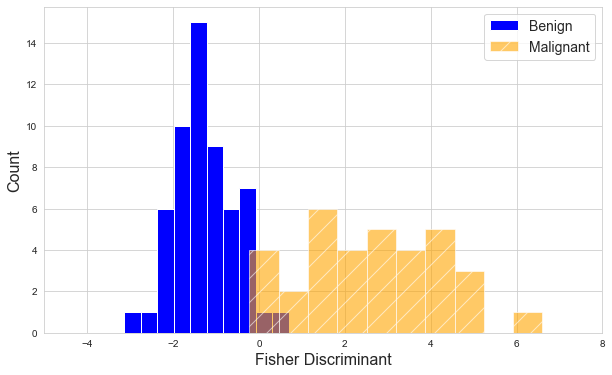

In [25]:
plt.figure(figsize=(10,6))

plt.hist(pipe.transform(X_val)[y_val==0], color='blue', label="Benign")
plt.hist(pipe.transform(X_val)[y_val==1], color='orange', hatch='/', alpha=.6, label="Malignant")

plt.xlabel("Fisher Discriminant", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.legend(fontsize=14)

plt.xlim([-5,8])

plt.show()

I would say that there does appear to be slightly more overlap for the validation data than the training data, but this is still a good amount of separation.

<i>For those interested in how the supervised dimension reduction aspect of LDA works see the `Bayes Based Classifiers` `Practice Problems` notebook.</i>

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2022.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)